# Intra-frame analysis of thermal effects

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [23]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer
from usnm2p.wfutils import get_onoff_times

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [24]:
analysis_type = 'main'  # Analysis type
mouseline = 'line3'
layer = None  # cortical layer
slack_notify = False

### Load data

In [34]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# Load data from each file into a dictionary
dFF, info_table = {}, {}
for fname in datafiles:
    dataset_ID = os.path.splitext(fname)[0]
    dFF[dataset_ID], info_table[dataset_ID] = load_rowavg_dataset(os.path.join(datadir, fname))

# Assemble into multi-indexed pandas Series
logger.info(f'assembling {len(dFF)} datasets into single multi-indexed series')
dFF = pd.concat(dFF, axis=0, names=[Label.DATASET])

# Assemble info table into single DataFrame
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET])
info_table = add_intensity_to_table(info_table, precision=2)
info_table

# Extract PRF, duration, and number of pulses from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
npulses = int(dur * PRF)

# Create a mapping from ISPTA to DC
ispta_DC_map = info_table.groupby(Label.ISPTA).first()[Label.DC]

# Extract stimulus onset time from info table, and construct FrameIndexer
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
tref = get_stim_onset_time(mouseline)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial).resample(lpf)

 2025/07/02 00:13:30: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/line3
 2025/07/02 00:13:30: loading row-average dFF data from 20191107_mouse1_region1.h5
 2025/07/02 00:13:30: loading experiment info table...
 2025/07/02 00:13:30: loading row-average dFF data from 20191113_mouse9_region2.h5
 2025/07/02 00:13:30: loading experiment info table...
 2025/07/02 00:13:30: loading row-average dFF data from 20191108_mouse6_region2.h5
 2025/07/02 00:13:30: loading experiment info table...
 2025/07/02 00:13:30: loading row-average dFF data from 20200313_mouse14_region1.h5
 2025/07/02 00:13:31: loading experiment info table...
 2025/07/02 00:13:31: loading row-average dFF data from 20191024_mouse5_region1.h5
 2025/07/02 00:13:31: loading experiment info table...
 2025/07/02 00:13:31: loading row-average dFF data from 20190829_mouse10_region1.h5
 2025/07/02 00:13:31: loading experiment info table...
 2025/07/02 00:13:31: loading row-average dFF data from 20190704_mouse3_

### Average across trials, and add experiment info table

In [ ]:
# Average across trials
logger.info('averaging across trials')
trialagg_dFF = dFF.groupby([Label.DATASET, Label.RUN, Label.FRAMEROW]).mean()

# Subtract pre-stimulus baseline levels for each dataset and run
logger.info('subtracting pre-stimulus baseline levels')
gby = [Label.DATASET, Label.RUN]
def subtract_baseline(y):
    y0 = y.droplevel(gby).loc[:fidx.iref].median()
    return y - y0
trialagg_dFF = trialagg_dFF.groupby([Label.DATASET, Label.RUN]).transform(subtract_baseline)

# Add info table to trial-aggregated dFF
trialagg_dFF = free_expand_and_add(info_table, trialagg_dFF.to_frame())

# Remove data for DC = 1%
logger.info('removing data for DC = 1%')
trialagg_dFF = trialagg_dFF[trialagg_dFF[Label.DC] != 1.0]

# Add time vector to trial-aggregated dFF
add_time_to_table(trialagg_dFF, fidx=fidx, fps=fps * lpf)

 2025/07/02 00:07:52: averaging across trials


### Define plot function

In [39]:
def plot_dFF_vs_ispta(data, tbounds=None):
    ''' 
    Plot trial-averaged dFF across datasets, per ISPTA.

    :param data: DataFrame containing trial-averaged dFF data
    :param tbounds (optional): tuple of time bounds (start, end) to restrict the data for plotting
    :return: matplotlib figure object
    '''
    s = 'plotting trial-averaged averaged dFF'
    if tbounds is not None:
        s += f' between {tbounds[0]} and {tbounds[1]} s'
    logger.info(s)

    # If specified, restrict time bounds
    if tbounds is not None:
        data = data[data[Label.TIME].between(*tbounds)]

    # Create a FacetGrid to plot dFF profile per ISPTA 
    g = sns.FacetGrid(
        data=data,
        col=Label.ISPTA,
        col_wrap=2,
        height=2,
        aspect=2.5,
    )

    # Plot across datasets
    if Label.DATASET in data.index.names:
        g.map_dataframe(
            sns.lineplot,
            x=Label.TIME,
            y=Label.DFF,
            units=Label.DATASET,
            estimator=None,
            color='silver',
            alpha=0.5,
            legend=False,
        )

    # Plot global average
    g.map_dataframe(
        sns.lineplot,
        x=Label.TIME,
        y=Label.DFF,
        errorbar=None,
        color='k'
    )

    # If time interval is narrow, add vertical spans for stimulus trigger and individual pulses
    if np.ptp(data[Label.TIME]) < 1:
        for ispta, ax in g.axes_dict.items():
            ax.axvline(0, c='k', ls='--', label='stimulus trigger')
            if ispta > 0:
                tpulses = get_onoff_times(dur, PRF, ispta_DC_map.loc[ispta], onset=STIM_TRIG_DELAY)
                for tp in tpulses:
                    ax.axvspan(*tp, fc='brown', alpha=0.5)
    # Otherwise, add single vertical spans for stimulus
    else:
        for ax in g.axes:
            ax.axvspan(0, 0.2, fc='brown', alpha=0.5, label='stimulus')

    # Return figure object
    return g.fig

### Plot trial-aggregated dFF vs ISPTA, across datasets (default and zoom-in around stimulus)

 2025/07/02 00:17:02: plotting trial-averaged averaged dFF between -1 and 5 s
 2025/07/02 00:17:35: plotting trial-averaged averaged dFF between -0.1 and 0.3 s


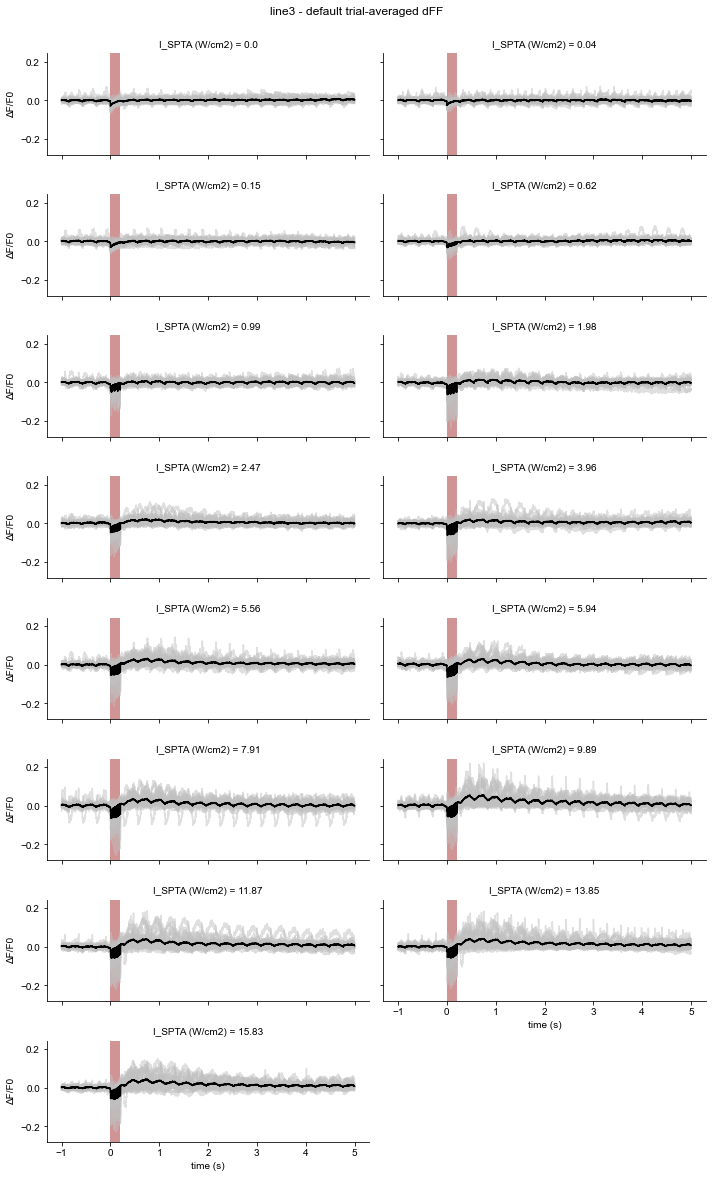

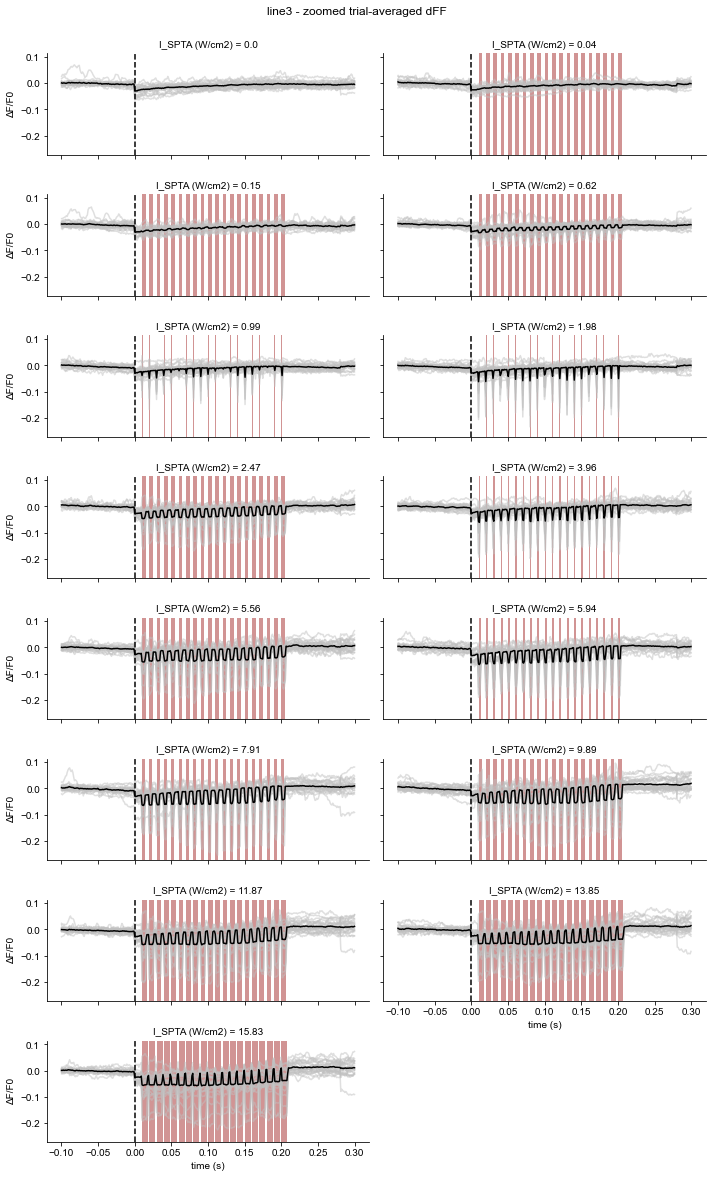

In [40]:
# Restrict time bounds for plotting 
tbounds = {
    'default': (-1, 5),  # Default time bounds
    'zoomed': (-0.1, 0.3)  # Time bounds around stimulus
}
for k, v in tbounds.items():
    figs[k] = plot_dFF_vs_ispta(trialagg_dFF.copy(), tbounds=v)
    figs[k].suptitle(f'{mouseline} - {k} trial-averaged dFF', y=1.02)

### Agverage across datasets

 2025/07/02 00:18:09: plotting trial-averaged averaged dFF between -1 and 5 s
 2025/07/02 00:18:11: plotting trial-averaged averaged dFF between -0.1 and 0.3 s


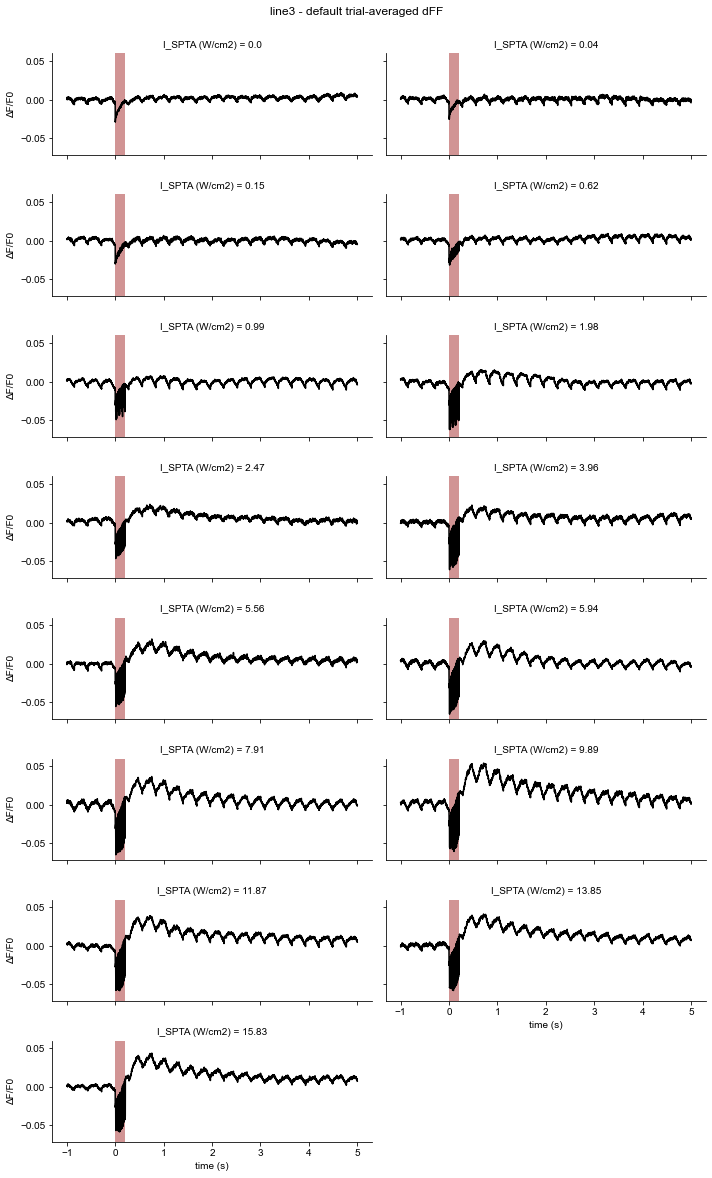

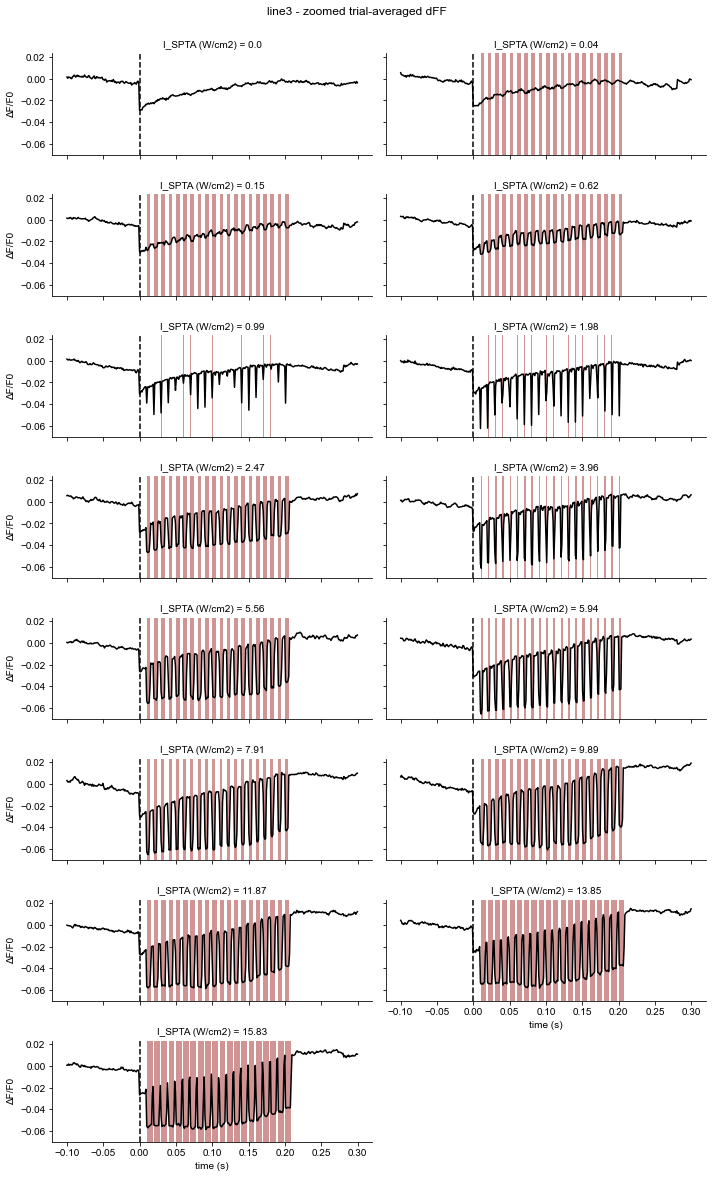

In [41]:
agg_funcs = {k: 'first' for k in trialagg_dFF.columns}
agg_funcs[Label.DFF] = 'mean'  # specific aggregation for dFF
del agg_funcs['code']
avg_trialagg_dFF = trialagg_dFF.groupby([Label.ISPTA, Label.FRAMEROW]).agg(agg_funcs)

for k, v in tbounds.items():
    figs[k] = plot_dFF_vs_ispta(avg_trialagg_dFF.copy(), tbounds=v)
    figs[k].suptitle(f'{mouseline} - {k} trial-averaged dFF', y=1.02)

### Deconstruct dFF profile during stimulus

mixture of:
- 3.5 Hz oscillation, coming from the line scanning through FOV (can be predicted from previous frames)
- trigger-induced initial DC dip + exponential decay recovery, probably coming from hardware/acquisition artifacts (also present at P = 0)
- DC offset during each US pulse in the pulse train, with full recovery between pulses

algorithm to deconstruct dFF profile during stimulus
1. remove 3.5 Hz oscillation by subtracting profile from previous frame(s)
2. remove trigger-induced initial DC dip + exponential decay recovery, fitted to profile at I = 0
3. quantify DC offset during each US pulse, stationarity within and across pulses, recoveries between pulses, etc.

In [44]:
# TODO